In [4]:
import pandas as pd

In [5]:
df1 = pd.read_csv(r'C:\Users\Johannes\Documents\Uni\Master\Tech_Labs\ws24-skillswap\DS\01_Notebooks\01_Synthetic_Data_Set\Skillswap_Data_Labeled.csv')
pd.set_option('display.max_columns', None)

df1.head()

,First_Name,EMail,Age,Gender,Location_Preferences,Latitude,Longitude,Country,City,Languages_Preferred,Last_Seen,Response_Time,Farming_off,Fishery_off,Gardening_off,Pet grooming_off,Pet training_off,Drawing_off,Painting_off,Sculpture_off,Print making_off,Poetry_off,Make-up_off,Facials_off,Pedicure & Manicure_off,Hair care_off,Ballet_off,Tap dance_off,Jazz dance_off,Salsa_off,Ballroom dance_off,Piano_off,Guitar_off,Drumming_off,Trumpet_off,Composing_off,Script writing_off,Play writing_off,Poetry writing_off,Caligraphy_off,Blogging_off,Journalism_off,German_off,Spanish_off,Arabic_off,French_off,English_off,Nutrition_off,Fitness & Excercise_off,Wellness_off,Tennis_off,Football_off,Basketball_off,Yoga_off,Baseball_off,Gymnastic_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Programming_off,Graphic design_off,Data Analysis_off,Photoshop_off,Social Media_off,Camera handling_off,Photo editing_off,Lighting_off,Landscape photography_off,Portrait photography_off,Image processing_off,Video editing_off,Film making_off,Animation_off,Motion graphics_off,Visual effects_off,Farming_dem,Fishery_dem,Gardening_dem,Pet grooming_dem,Pet training_dem,Drawing_dem,Painting_dem,Sculpture_dem,Print making_dem,Poetry_dem,Make-up_dem,Facials_dem,Pedicure & Manicure_dem,Hair care_dem,Ballet_dem,Tap dance_dem,Jazz dance_dem,Salsa_dem,Ballroom dance_dem,Piano_dem,Guitar_dem,Drumming_dem,Trumpet_dem,Composing_dem,Script writing_dem,Play writing_dem,Poetry writing_dem,Caligraphy_dem,Blogging_dem,Journalism_dem,German_dem,Spanish_dem,Arabic_dem,French_dem,English_dem,Nutrition_dem,Fitness & Excercise_dem,Wellness_dem,Tennis_dem,Football_dem,Basketball_dem,Yoga_dem,Baseball_dem,Gymnastic_dem,Cooking_dem,Baking_dem,Grilling_dem,Meal planning_dem,Sautéing_dem,Programming_dem,Graphic design_dem,Data Analysis_dem,Photoshop_dem,Social Media_dem,Camera handling_dem,Photo editing_dem,Lighting_dem,Landscape photography_dem,Portrait photography_dem,Image processing_dem,Video editing_dem,Film making_dem,Animation_dem,Motion graphics_dem,Visual effects_dem,Count_Farming_off,Count_Fishery_off,Count_Gardening_off,Count_Pet_grooming_off,Count_Pet_training_off,Count_Drawing_off,Count_Painting_off,Count_Sculpture_off,Count_Print_making_off,Count_Poetry_off,Count_Make_up_off,Count_Facials_off,Count_Pedicure_and_Manicure_off,Count_Hair_care_off,Count_Ballet_off,Count_Tap_dance_off,Count_Jazz_dance_off,Count_Salsa_off,Count_Ballroom_dance_off,Count_Piano_off,Count_Guitar_off,Count_Drumming_off,Count_Trumpet_off,Count_Composing_off,Count_Script_writing_off,Count_Play_writing_off,Count_Poetry_writing_off,Count_Caligraphy_off,Count_Blogging_off,Count_Journalism_off,Count_German_off,Count_Spanish_off,Count_Arabic_off,Count_French_off,Count_English_off,Count_Nutrition_off,Count_Fitness_and_Excercise_off,Count_Wellness_off,Count_Tennis_off,Count_Football_off,Count_Basketball_off,Count_Yoga_off,Count_Baseball_off,Count_Gymnastic_off,Count_Cooking_off,Count_Baking_off,Count_Grilling_off,Count_Meal_planning_off,Count_Sautéing_off,Count_Programming_off,Count_Graphic_design_off,Count_Data_Analysis_off,Count_Photoshop_off,Count_Social_Media_off,Count_Camera_handling_off,Count_Photo_editing_off,Count_Lighting_off,Count_Landscape_photography_off,Count_Portrait_photography_off,Count_Image_processing_off,Count_Video_editing_off,Count_Film_making_off,Count_Animation_off,Count_Motion_graphics_off,Count_Visual_effects_off,Count_Poetry writing_off,Count_Landscape photography_off,Count_Photo editing_off,Count_Motion graphics_off,Count_Social Media_off,Count_Hair care_off,Count_Film making_off,Count_Play writing_off,Count_Print making_off,Count_Visual effects_off,Count_Meal planning_off,Count_Data Analysis_off,Count_Video editing_off,Count_Fitness & Excercise_off,Count_Pet grooming_off,Count_Graphic design_off,Count_Pet training_off,Count_Pedicure & Manicure_off,Count_Jazz dance_off,Count_Camera handling_off,Count_Portrait photography_off,Count_Make-up_off,Count_Ballroom dance_o

# Goal: Get the 10 closest "Super Swaps": Matches where both parties can serve each others skill interests

# 1. Select a random user

In [6]:
# Select Random User and show the skill portfolio and the skill interests
random_row = df1.sample()

selected_columns = random_row[['First_Name', 'Latitude', 'Longitude', 'Location_Preferences', 'Activity_Status']]

off_columns = [col for col in df1.columns if col.endswith('_off') and not pd.isna(random_row[col].values[0])]
selected_off_columns = random_row[off_columns]
columns_to_drop = [col for col in selected_off_columns.columns if col.startswith("Count_")]
selected_off_columns.drop(columns=columns_to_drop, inplace=True)

dem_columns = [col for col in df1.columns if col.endswith('_dem') and random_row[col].values[0] != 0]
selected_dem_columns = random_row[dem_columns]

df2 = pd.concat([selected_columns, selected_off_columns, selected_dem_columns], axis=1)
df2

C:\Users\Johannes\AppData\Local\Temp\ipykernel_12864\3160578494.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_off_columns.drop(columns=columns_to_drop, inplace=True)


,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Pet grooming_off,Pet training_off,Camera handling_off,Photo editing_off,Lighting_off,Landscape photography_off,Portrait photography_off,Image processing_off,Make-up_dem,Facials_dem,Pedicure & Manicure_dem,Hair care_dem,Tennis_dem,Football_dem,Basketball_dem,Yoga_dem,Baseball_dem,Gymnastic_dem,Cooking_dem,Baking_dem,Grilling_dem,Meal planning_dem,Sautéing_dem,Programming_dem,Graphic design_dem,Data Analysis_dem,Photoshop_dem,Social Media_dem,Video editing_dem,Film making_dem,Animation_dem,Motion graphics_dem,Visual effects_dem
388,Victor,52.339275,13.544649,Local Only,Swapper,Intermediate,Novice,Beginner,Beginner,Beginner,Novice,Expert,Intermediate,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


# 2. Find the right matches for the random user

## 2.1. Find the other users that offer skills the random user is interested in

In [7]:

# Step 1: Take the columns from df2 that end with "_dem"
df2_columns = [col for col in df2.columns if col.endswith('_dem')]

# Step 2: Replace the "_dem" with "_off"
df2_columns_off = [col.replace('_dem', '_off') for col in df2_columns]

# Step 3: Check if there are columns in the DataFrame df1 that match the names of the columns from step 2
matching_columns = [col for col in df1.columns if col in df2_columns_off]

# Step 4: Create a new DataFrame showing all rows where at least one of these columns has a value that is not NaN and exclude the row with the index of the rows in df2
selected_rows = df1[df1[matching_columns].notnull().any(axis=1) & ~df1.index.isin(df2.index)]


## 2.2 From the skill columns display only the columns that match the random user's interests and the random user's skill portfolio (indicating which skills the random user offers)

In [8]:
# Step 1: Select the required columns
selected_columns = ['First_Name', 'Latitude', 'Longitude', 'Location_Preferences', 'Activity_Status']

# Select columns ending with "_off" and not NaN
selected_off_columns = [col for col in selected_rows.columns if col.endswith('_off') and col in df2_columns_off and not selected_rows[col].isna().all()]

# Select columns ending with "_dem" and not "0" and match the offering of the random user
selected_rows_columns = [col for col in df2.columns if col.endswith('_off')]
selected_rows_columns_dem = [col.replace('_off', '_dem') for col in selected_rows_columns]

selected_dem_columns = [col for col in selected_rows.columns if col.endswith('_dem') and col in selected_rows_columns_dem and (selected_rows[col] != 0).any()]

# Add the selected columns to the list
selected_columns.extend(selected_off_columns)
selected_columns.extend(selected_dem_columns)

# Extract the required DataFrame with selected columns
potential_matches = selected_rows[selected_columns]
potential_matches.head()

,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Make-up_off,Facials_off,Pedicure & Manicure_off,Hair care_off,Tennis_off,Football_off,Basketball_off,Yoga_off,Baseball_off,Gymnastic_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Programming_off,Graphic design_off,Data Analysis_off,Photoshop_off,Social Media_off,Video editing_off,Film making_off,Animation_off,Motion graphics_off,Visual effects_off,Pet grooming_dem,Pet training_dem,Camera handling_dem,Photo editing_dem,Lighting_dem,Landscape photography_dem,Portrait photography_dem,Image processing_dem
3,Emilio,52.450986,13.199572,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,Novice,Expert,Novice,Beginner,Expert,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
5,Clifford,52.530867,13.203350,Local or Remote,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,Novice,Beginner,Expert,Novice,0,0,0,0,0,0,0,0
6,Mihrab,52.648858,13.342033,Remote Only,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Advanced,Novice,Novice,Novice,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0
7,Paige,52.365139,13.459380,Remote Only,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,Novice,Intermediate,Beginner,Expert,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,1,1,1
8,Cláudio,52.532445,13.644201,Local or Remote,Swapper,Intermediate,Advanced,Novice,Expert,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0


## 2.3 Filter for the other users that are also interested in the skills the random user offers

In [9]:
Perfect_Matches = pd.DataFrame()

# Create an empty list to store rows for Perfect_Matches
perfect_matches_rows = []

# Create a list of all columns that contain the skill interests of the other users
potential_matches_columns = [col for col in potential_matches.columns if col.endswith('_dem')]

# Iterate over each row in potential_matches
for index, row in potential_matches.iterrows():
    # Check if all columns ending with "_dem" contain a 0
    if not all(row[col] == 0 for col in potential_matches_columns):
        # Store the original index in a column named "OG_Index"
        row['OG_Index'] = index
        # Include the remaining rows in the list for Perfect_Matches
        perfect_matches_rows.append(row)

# Create Perfect_Matches DataFrame from the collected rows
Perfect_Matches = pd.DataFrame(perfect_matches_rows)

# Reorder the columns to have "OG_Index" at the beginning
cols = Perfect_Matches.columns.tolist()
cols = ['OG_Index'] + [col for col in cols if col != 'OG_Index']
Perfect_Matches = Perfect_Matches[cols]

# Reset the index of Perfect_Matches
Perfect_Matches.reset_index(drop=True, inplace=True)
Perfect_Matches


,OG_Index,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Make-up_off,Facials_off,Pedicure & Manicure_off,Hair care_off,Tennis_off,Football_off,Basketball_off,Yoga_off,Baseball_off,Gymnastic_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Programming_off,Graphic design_off,Data Analysis_off,Photoshop_off,Social Media_off,Video editing_off,Film making_off,Animation_off,Motion graphics_off,Visual effects_off,Pet grooming_dem,Pet training_dem,Camera handling_dem,Photo editing_dem,Lighting_dem,Landscape photography_dem,Portrait photography_dem,Image processing_dem
0,7,Paige,52.365139,13.459380,Remote Only,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,Novice,Intermediate,Beginner,Expert,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,1,1,1
1,10,Piergiorgio,52.591045,13.246717,Local or Remote,Swapper,NaN,NaN,NaN,NaN,Intermediate,Novice,Novice,Novice,Beginner,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1
2,12,Marc,52.412190,13.164528,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Advanced,Expert,Beginner,Intermediate,Intermediate,1,1,0,0,0,0,0,0
3,17,Édouard,52.439702,13.242511,Remote Only,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Beginner,Beginner,Beginner,Expert,1,1,0,0,0,0,0,0
4,20,Isabelle,52.381180,13.465698,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Advanced,Novice,Intermediate,Advanced,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,726,Zoe,52.493841,13.391201,Remote Only,Swapper,Expert,Novice,Novice,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert,Beginner,Novice,Intermediate,Intermediate,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1
164,735,Ernest,52.365800,13.555038,Remote Only,Inactive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert,Intermediate,Advanced,Novice,Beginner,1,1,1,1,1,1,1,1
165,737,Gilberto,52.371065,13.200415,Remote Only,Occasional User,NaN,NaN,NaN,NaN,Novice,Intermediate,Advanced,Intermediate,Expert,Intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Intermediate,Intermediate,Novice,Beginner,1,1,0,0,0,0,0,0
166,744,Bruno,52.401653,13.739822,Local or Remote,Swapper,Beginner,Novice,Novice,Intermediate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,1,1,1,1,1


## 2.4 Get rid of inactive users & users that are not available for in-person meetings 

In [10]:
Perfect_Matches_filtered = Perfect_Matches[(Perfect_Matches['Activity_Status'] != 'Inactive') & (Perfect_Matches['Location_Preferences'] != 'Remote Only')]
Perfect_Matches_filtered.head()

,OG_Index,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Make-up_off,Facials_off,Pedicure & Manicure_off,Hair care_off,Tennis_off,Football_off,Basketball_off,Yoga_off,Baseball_off,Gymnastic_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Programming_off,Graphic design_off,Data Analysis_off,Photoshop_off,Social Media_off,Video editing_off,Film making_off,Animation_off,Motion graphics_off,Visual effects_off,Pet grooming_dem,Pet training_dem,Camera handling_dem,Photo editing_dem,Lighting_dem,Landscape photography_dem,Portrait photography_dem,Image processing_dem
1,10,Piergiorgio,52.591045,13.246717,Local or Remote,Swapper,NaN,NaN,NaN,NaN,Intermediate,Novice,Novice,Novice,Beginner,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1
2,12,Marc,52.412190,13.164528,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Advanced,Expert,Beginner,Intermediate,Intermediate,1,1,0,0,0,0,0,0
4,20,Isabelle,52.381180,13.465698,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Advanced,Novice,Intermediate,Advanced,1,1,0,0,0,0,0,0
5,21,Léon,52.617792,13.544180,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,Beginner,Intermediate,Beginner,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1
7,25,Dorota,52.400790,13.106629,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Expert,Novice,Expert,Beginner,Advanced,NaN,NaN,NaN,NaN,NaN,1,1,1,1,1,1,1,1


# 3. Plot the locations of users that would make perfect matches

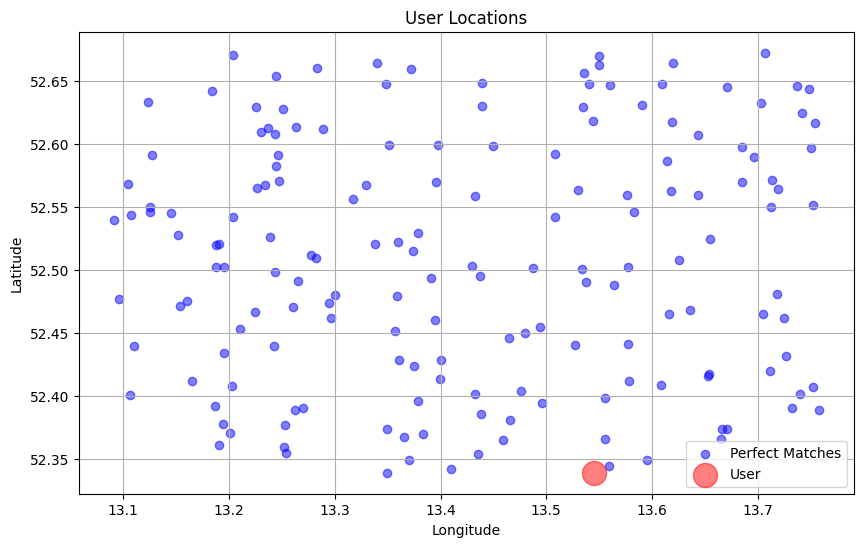

In [11]:
import matplotlib.pyplot as plt

# Plot Latitude vs Longitude for Perfect_Matches DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(Perfect_Matches['Longitude'], Perfect_Matches['Latitude'], color='blue', alpha=0.5, label='Perfect Matches')

# Plot Latitude vs Longitude for df2 DataFrame
plt.scatter(df2['Longitude'], df2['Latitude'], color='red', alpha=0.5, label='User', s=300)

plt.title('User Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True)
plt.show()


# 4. Get 10 closest matches

In [12]:
# Create one concatenated dataframe 

Match_Coordinates = Perfect_Matches_filtered.drop(columns=['OG_Index'])

concatenated_df = pd.concat([df2, Match_Coordinates])
concatenated_df.reset_index(drop=True, inplace=True)
concatenated_df.head()

,First_Name,Latitude,Longitude,Location_Preferences,Activity_Status,Pet grooming_off,Pet training_off,Camera handling_off,Photo editing_off,Lighting_off,Landscape photography_off,Portrait photography_off,Image processing_off,Make-up_dem,Facials_dem,Pedicure & Manicure_dem,Hair care_dem,Tennis_dem,Football_dem,Basketball_dem,Yoga_dem,Baseball_dem,Gymnastic_dem,Cooking_dem,Baking_dem,Grilling_dem,Meal planning_dem,Sautéing_dem,Programming_dem,Graphic design_dem,Data Analysis_dem,Photoshop_dem,Social Media_dem,Video editing_dem,Film making_dem,Animation_dem,Motion graphics_dem,Visual effects_dem,Make-up_off,Facials_off,Pedicure & Manicure_off,Hair care_off,Tennis_off,Football_off,Basketball_off,Yoga_off,Baseball_off,Gymnastic_off,Cooking_off,Baking_off,Grilling_off,Meal planning_off,Sautéing_off,Programming_off,Graphic design_off,Data Analysis_off,Photoshop_off,Social Media_off,Video editing_off,Film making_off,Animation_off,Motion graphics_off,Visual effects_off,Pet grooming_dem,Pet training_dem,Camera handling_dem,Photo editing_dem,Lighting_dem,Landscape photography_dem,Portrait photography_dem,Image processing_dem
0,Victor,52.339275,13.544649,Local Only,Swapper,Intermediate,Novice,Beginner,Beginner,Beginner,Novice,Expert,Intermediate,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Piergiorgio,52.591045,13.246717,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Intermediate,Novice,Novice,Novice,Beginner,Novice,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,Marc,52.412190,13.164528,Local or Remote,Occasional User,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Advanced,Expert,Beginner,Intermediate,Intermediate,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Isabelle,52.381180,13.465698,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Novice,Advanced,Novice,Intermediate,Advanced,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Léon,52.617792,13.544180,Local or Remote,Swapper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Beginner,Beginner,Intermediate,Beginner,Beginner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
import numpy as np

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

# Take the first row of concatenated_df and extract the Latitude and Longitude
target_coordinate = concatenated_df[['Latitude', 'Longitude']].iloc[0]

# Calculate Euclidean distance for all rows in concatenated_df except the first row
distances = []
for index, row in concatenated_df.iloc[1:].iterrows():
    distance = euclidean_distance(row[['Latitude', 'Longitude']], target_coordinate)
    distances.append((index, distance))

# Sort distances
distances.sort(key=lambda x: x[1])

# Get the indices of the closest 10 points
closest_indices = [index for index, _ in distances[:10]]

# Extract the closest coordinates
closest_coordinates = concatenated_df.loc[closest_indices, ['Latitude', 'Longitude']]

# Step 1: Get the indices of closest_coordinates
# Step 2: Use the indices to locate the respective rows in concatenated_df
# Step 3: Extract the desired columns
# Step 4: Create a new DataFrame with the selected rows

closest_indices = closest_coordinates.index
selected_rows = concatenated_df.loc[closest_indices]
selected_rows_subset = selected_rows.iloc[:, :4]


selected_rows_subset

,First_Name,Latitude,Longitude,Location_Preferences
35,Richard,52.348936,13.594841,Local or Remote
23,Baytal,52.398050,13.555892,Local or Remote
13,Fiorino,52.411712,13.578147,Local or Remote
3,Isabelle,52.381180,13.465698,Local or Remote
66,Odalys,52.409107,13.608345,Local or Remote
18,Georgina,52.440073,13.526852,Local Only
77,Elhan,52.440996,13.577158,Local or Remote
78,Mohammed,52.373632,13.665809,Local or Remote
34,Denis,52.449576,13.479984,Local or Remote
25,Daniel,52.401916,13.432113,Local Only


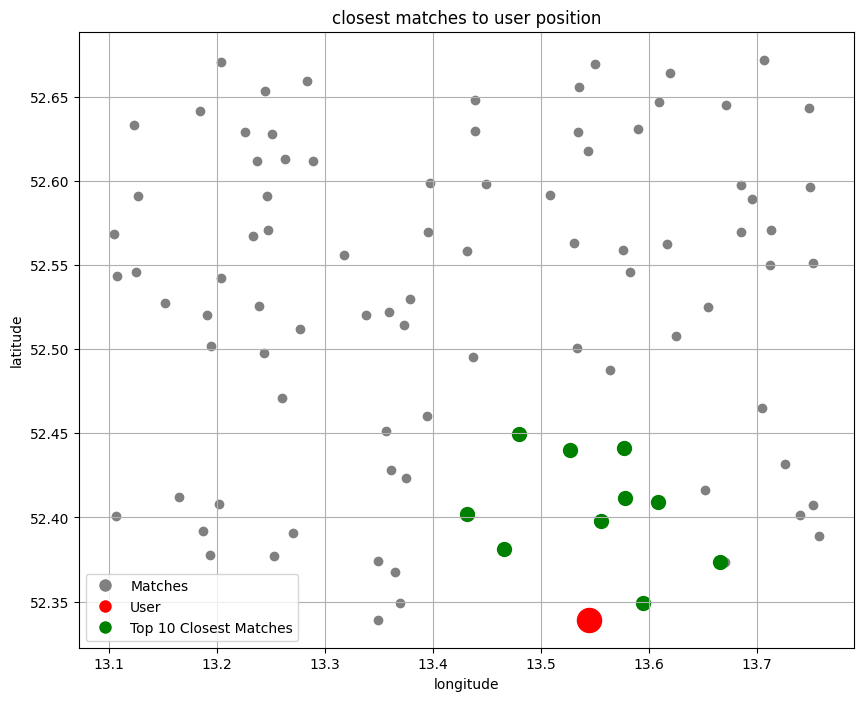

In [16]:
import matplotlib.pyplot as plt

# Plotting the data points
plt.figure(figsize=(10, 8))

# Plotting all data points in concatenated_df
plt.scatter(concatenated_df['Longitude'], concatenated_df['Latitude'], color='grey', label='All Data Points')

# Plotting the target coordinate (first row of concatenated_df)
plt.scatter(target_coordinate['Longitude'], target_coordinate['Latitude'], color='red', label='Target Coordinate', s=300)

# Plotting the closest coordinates to the target
plt.scatter(closest_coordinates['Longitude'], closest_coordinates['Latitude'], color='green', label='Closest Points', s=100)

# Adding labels and title
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('closest matches to user position')
# Create custom legend handles with the same size as the largest one
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='grey'),
                  plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='red'),
                  plt.Line2D([0], [0], marker='o', color='w', markersize=10, markerfacecolor='green')]
plt.legend(legend_handles, ['Matches', 'User', 'Top 10 Closest Matches'])

plt.grid(True)

# Displaying the plot
plt.show()


In [17]:
import folium
from folium.plugins import HeatMap

# Create a base map centered around Berlin
berlin_map = folium.Map(location=[52.52, 13.405], zoom_start=12)

data_points = list(zip(concatenated_df['Latitude'], concatenated_df['Longitude']))

HeatMap(data_points).add_to(berlin_map)

folium.Marker(location=[target_coordinate['Latitude'], target_coordinate['Longitude']], popup='Your Position', icon=folium.Icon(color='red')).add_to(berlin_map)
for index, row in selected_rows_subset.iterrows():
    folium.Marker(location=[row['Latitude'], row['Longitude']], popup=f'{row["First_Name"]}', icon=folium.Icon(color='green')).add_to(berlin_map)

berlin_map